In [2]:
from itertools import combinations
import math
import networkx
import matplotlib.pyplot as plt

In [3]:
data = {
    0: [(0,0),0],
    1: [(-3,3),5],
    2: [(1,11),4],
    3: [(4,7),3],
    4: [(-5,9),6],
    5: [(-5,-2),7],
    6: [(-4,-7),3],
    7: [(6,0),4],
    8: [(3,-6),6],
    9: [(-1,-3),5],
    10: [(0,-6),4],
    11: [(6,4),7],
    12: [(2,5),3],
    13: [(-2,8),4],
    14: [(6,10),5],
    15: [(1,8),6],
    16: [(-3,1),8],
    17: [(-6,5),5],
    18: [(2,9),7],
    19: [(-6,-5),6],
    20: [(5,-4),6]
}

In [4]:
xy = {
    0: (0,0),
    1: (-3,3),
    2: (1,11),
    3: (4,7),
    4: (-5,9),
    5: (-5,-2),
    6: (-4,-7),
    7: (6,0),
    8: (3,-6),
    9: (-1,-3),
    10: (0,-6),
    11: (6,4),
    12: (2,5),
    13: (-2,8),
    14: (6,10),
    15: (1,8),
    16: (-3,1),
    17: (-6,5),
    18: (2,9),
    19: (-6,-5),
    20: (5,-4)
}

In [4]:
# List of farm  including the depot
farms = [*range(0,21)]

# List of farms that are visited everyday
everyDay = [*range(0,10)]

# List of farms that are visited each other day
otherDay = [*range(10,21)]

# List of day types
dayType = [1,2]

# Tanker lorry capacity (1,000)
tankerCap = 80

# Every day farms requirements
everyDayReq = 0
for i in everyDay:
    everyDayReq += data[i][1]

In [5]:
# Compute pairwise distance matrix
# numpy linalg norm = euclidean n=2

def distance(city1, city2):
    c1 = data[city1][0]
    c2 = data[city2][0]
    diff = (c1[0]-c2[0], c1[1]-c2[1])
    return math.sqrt(diff[0]*diff[0]+diff[1]*diff[1])

dist = {(c1, c2): distance(c1, c2) for c1, c2 in combinations(farms, 2)}

In [6]:
import pyscipopt as scip
from pyscipopt import Model, Heur, Eventhdlr, Conshdlr, quicksum, SCIP_RESULT, SCIP_EVENTTYPE, SCIP_HEURTIMING

In [72]:
m = scip.Model()
edges = list(dist.keys())


Decision variables 

In [73]:
# Edge variables = 1, if farm 'i' is adjacent to farm 'j' on the tour of day type 'k'.
x = dict()
for i in farms:
    for j in farms:
        if i < j:
            for k in dayType:
                x[(i,j,k)] = m.addVar(vtype="B",name="x(%s,%s,%s)"%(i,j,k))
# Other day variables = 1, if farm 'i' is visited on the tour of day type 'k'.
y = dict()
for i in otherDay:
    for k in dayType:
        y[(i,k)] = m.addVar(vtype="B",name="y(%s,%s)"%(i,k))
# Symmetry constraints: copy the object (not a constraint)
for i,j,k in list(x.keys()):
    x[(j, i, k)] = x[(i, j, k)]


constraints

In [74]:
# Tanker capacity constraint.
for k in dayType:
    m.addCons(scip.quicksum(data[i][1]*y[(i,k)] for i in otherDay) <= tankerCap - everyDayReq)

In [75]:
# Other day farms are visited on day type 1 or 2.
for i in otherDay:
    m.addCons(scip.quicksum(y[(i,k)] for k in dayType) == 1)

In [76]:
# 1. Every day constraints: two edges incident to an every day farm on tour of day type 'k'. 
for i in everyDay:
    for k in dayType:
        m.addCons(scip.quicksum(x[(i,j,k)] for j in farms if j>i) + 
                  scip.quicksum(x[(j,i,k)] for j in farms if j<i) == 2 )


In [77]:
# Other day constraints: two edges incident to an other day farm on tour of day type 'k'.
for i in otherDay:
    for k in dayType:
        m.addCons(scip.quicksum(x[(i,j,k)] for j in farms if j>i) + 
          scip.quicksum(x[(j,i,k)] for j in farms if j<i) == 2*y[(i,k)] )


In [78]:
# for i in otherDay:
#     for j in otherDay:
#         if j > i:
#             for k in dayType:
#                 m.addCons(x[(i,j,k)] - y[(i,k)] <= 0)
#     for j in farms:
#         if i > j:
#             for k in dayType:
#                 m.addCons(x[(j,i,k)] - y[(i,k)] <= 0)

In [79]:
# Avoid symmetric alternative solutions
m.chgVarLb(y[(otherDay[0],dayType[0])],1)

In [80]:
class SEC(Conshdlr):

    # method for creating a constraint of this constraint handler type
    def createCons(self, name, variables):
        model = self.model
        cons = model.createCons(self, name)
        
        # data relevant for the constraint; in this case we only need to know which
        # variables cannot form a subtour
        cons.data = {}
        cons.data['vars'] = variables
        return cons
    
    # find subtours in the graph induced by the edges {i,j} for which x[i,j] is positive
    # at the given solution; when solution is None, the LP solution is used
    def find_subtours(self, cons, solution = None):
        for k in dayType:
            edges = []
            x = cons.data['vars']
            for i in farms:
                for j in farms:
                    if i < j:
                        if self.model.getSolVal(solution, x[(i,j,k)]) > 0.5:
                            edges.append((i, j))

            G = networkx.Graph()
            G.add_edges_from(edges)
            components = list(networkx.connected_components(G))
            print(k,"XXXX",len(components),components)
            if len(components) != 1:
                return components
        return []


    # checks whether solution is feasible
    def conscheck(self, constraints, solution, check_integrality,
                  check_lp_rows, print_reason, completely, **results):
        
        # check if there is a violated subtour elimination constraint
        for cons in constraints:
            if self.find_subtours(cons, solution):
                return {"result": SCIP_RESULT.INFEASIBLE}
        
        # no violated constriant found -> feasible
        return {"result": SCIP_RESULT.FEASIBLE}

    
    # enforces the LP solution: searches for subtours in the solution and adds 
    # adds constraints forbidding all the found subtours
    def consenfolp(self, constraints, n_useful_conss, sol_infeasible):
        consadded = False
        for cons in constraints:
            subtours = self.find_subtours(cons)
            # if there are subtours
            if subtours:
                x = cons.data['vars']
                for k in dayType:
                    # add subtour elimination constraint for each subtour
                    for S in subtours:
                        self.model.addCons(quicksum(x[(i,j,k)] for i in S for j in S if j>i) <= len(S)-1)
                        consadded = True

        if consadded:
            return {"result": SCIP_RESULT.CONSADDED}
        return {"result": SCIP_RESULT.FEASIBLE}



    # this is rather technical and not relevant for the exercise. to learn more see 
    # https://scipopt.org/doc/html/CONS.php#CONS_FUNDAMENTALCALLBACKS
    def conslock(self, constraint, locktype, nlockspos, nlocksneg):
        pass

In [81]:
def addSubtourElimination(model, x):
    # create the constraint handler
    conshdlr = SEC()

    # Add the constraint handler to SCIP. We set check priority < 0 so that only integer feasible solutions
    # are passed to the conscheck callback
    model.includeConshdlr(conshdlr, "TSP", "TSP subtour eliminator", chckpriority = -10, enfopriority = -10)

    # create a subtour elimination constraint
    cons = conshdlr.createCons("no_subtour_cons", x)

    # add constraint to SCIP
    model.addPyCons(cons)

In [82]:
addSubtourElimination(m, x)


Objective

In [83]:
# Objective function: minimize total distance travel
m.setObjective(scip.quicksum(dist[i,j]*x[(i,j,k)] for i in farms for j in farms for k in dayType if i < j))

In [84]:
m.optimize()

1 XXXX 0 []
1 XXXX 1 [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}]
2 XXXX 1 [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}]
1 XXXX 1 [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}]
2 XXXX 2 [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 16, 17, 19, 20}, {18, 12, 15}]
1 XXXX 3 [{0, 17, 18, 2}, {1, 5, 6, 7, 8, 9, 10}, {19, 3, 20, 4}]
1 XXXX 2 [{0, 1, 3, 4, 5, 6, 8, 9, 17, 18, 20}, {10, 2, 19, 7}]
1 XXXX 1 [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}]
2 XXXX 3 [{0, 9, 19, 7}, {1, 4, 5, 6, 8, 17, 20}, {3, 2, 18}]
1 XXXX 2 [{0, 2, 3, 11, 12, 18}, {1, 4, 5, 6, 7, 8, 9, 10, 17}]
1 XXXX 3 [{0, 2, 3, 11, 12, 18}, {1, 4, 5, 7, 8, 17}, {9, 10, 6}]
1 XXXX 3 [{0, 2, 4, 11, 12, 18}, {1, 3, 7, 8, 17}, {9, 10, 5, 6}]
1 XXXX 1 [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18}]
2 XXXX 1 [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 19, 20}]
1 XXXX 2 [{0, 16, 17, 8}, {1, 2, 3, 4, 5, 6, 7, 9, 10, 18}]
1 XX

In [85]:
m.getStatus()

'optimal'

In [86]:
print(f"The optimal distance traveled is: {10*round(m.getObjVal())} miles.")


The optimal distance traveled is: 1230 miles.


[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16, 17, 19}]


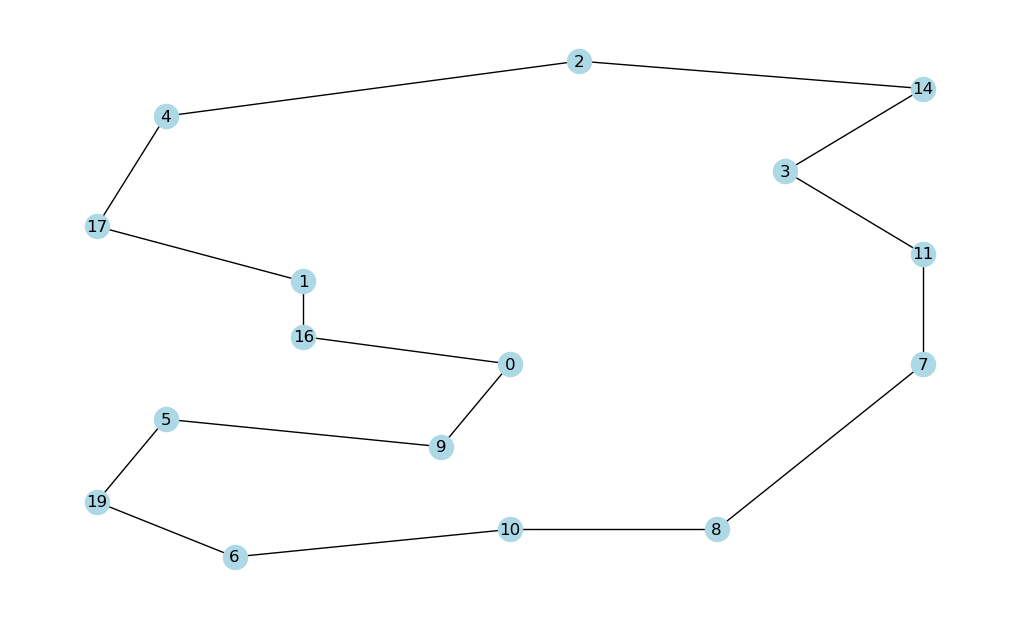

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 15, 18, 20}]


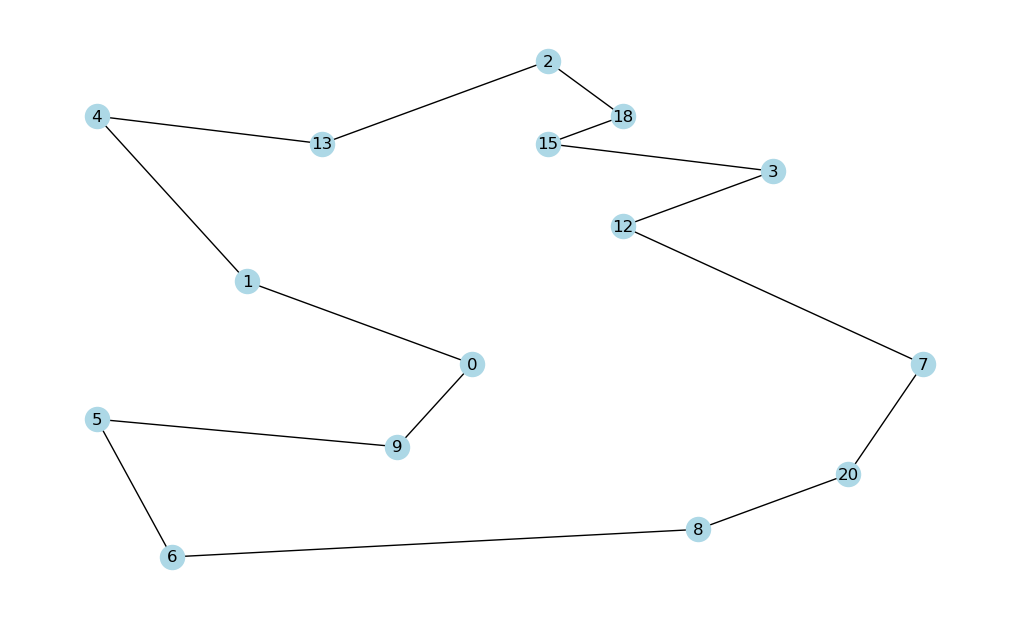

In [87]:
sol = m.getBestSol()
for k in dayType:
    # Collect the edges: if the value of x[i,j] is 1, then the edge (i,j) is in the solution
    edges = []
    for i in farms:
        for j in farms:
            if j > i:
                if m.getSolVal(sol, x[(i,j,k)]) > 0.5: # variable is binary so > 0.5 --> is 1
                    edges.append( (i,j) )
    # make figure look nicer
    plt.figure(figsize=(10,6), dpi=100)

    # create empty graph
    optgraph = networkx.Graph()

    # add edges
    optgraph.add_edges_from(edges)
    components = list(networkx.connected_components(optgraph))

    print(components)
    # draw the nodes, with labels in the position xy (see when we read the instance)
    networkx.draw(optgraph, node_size=300, pos=xy, with_labels=True, node_color='lightblue')

    # show drawing
    plt.show()

In [1]:
xy

NameError: name 'xy' is not defined